In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My\ Drive/MC_Project/

/content/gdrive/My Drive/MC_Project


**Reading the data**

In [ ]:
import pandas as pd

df = pd.read_csv('Final_Data.csv')
print(df.columns)

date_cgm = df['DateCGM'].tolist()
val_cgm = df['Value CGM'].tolist()
date_bolus = df['DateBolus'].tolist()
val_bolus = df['Value Bolus'].tolist()

date_cgm.reverse()
val_cgm.reverse()
date_bolus.reverse()
val_bolus.reverse()

In [ ]:
from datetime import datetime

new_df = pd.DataFrame(columns=['Time', 'BG', 'Value Bolus', 'Date', 'Hour', 'Label'])
time_list = []
bg_list = []
bolus_val = []
date_list = []
hour_list = []
label_list =[]


for i in range(len(date_cgm)):
  date_time_obj = datetime.strptime(date_cgm[i],'%Y-%m-%d %H:%M:%S.%f')
  time_list.append(date_cgm[i])
  bg_list.append(val_cgm[i])
  bolus_val.append(val_bolus[i])
  date_list.append(date_time_obj.date())
  hour_list.append(str(date_time_obj.time())[:2])

  if val_bolus[i] > 1:
    label_list.append('Meal')
  else:
    label_list.append('No Meal')


new_df['Time'] = time_list
new_df['BG'] = bg_list
new_df['Value Bolus'] = bolus_val
new_df['Date'] = date_list
new_df['Hour'] = hour_list
new_df['Label'] = label_list

new_df.to_csv('Updated_final_data.csv', index=False)

#date_time_obj = datetime.strptime(date_cgm[0], '%Y-%m-%d %H:%M:%S.%f')
#print(date_cgm[0])
#print(date_time_obj.date())
#print(str(date_time_obj.time())[:2])

In [ ]:
import pandas as pd

class DataGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p) for w, p in zip(s["BG"].values.tolist(), s["Label"].values.tolist())]
        self.grouped = self.data.groupby(["Date","Hour"]).apply(agg_func)
        print(len(self.grouped))
        self.vals = [s for s in self.grouped]
    
    def get_next(self):
        """Return one row of data"""
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

data = pd.read_csv("Updated_final_data.csv", index_col = False)
getter = DataGetter(data)
sent = getter.get_next()
print('This is what a row of data looks like:')
print(sent)

4091
This is what a row of data looks like:
[(314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal')]


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

     |████████████████████████████████| 747kB 16.9MB/s 


Using TensorFlow backend.


In [ ]:
rows = getter.vals
for s in rows:
  print(s)
len_s = [len(s) for s in rows]
print(max(len_s))

[(314.0, 'No Meal'), (314.0, 'No Meal')]
[(314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal')]
[(314.0, 'No Meal')]
[(314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal')]
[(314.0, 'No Meal')]
[(314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal')]
[(314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'Meal')]
[(314.0, 'No Meal'), (314.0, 'No Meal')]
[(314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal'), (314.0, 'No Meal')]
[(310.0, 'No Meal'), (310.0, 'No Meal'), (310.0, 'No Meal'), (310.0, 'No Meal'), (278.0, 'No M

<BarContainer object of 29 artists>

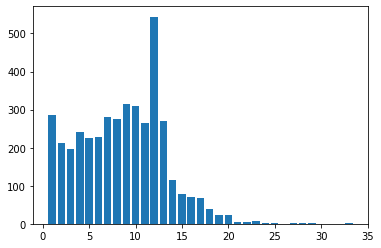

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

cnt = Counter(len_s)
plt.bar(cnt.keys(), cnt.values())

**Preparing the training and testing data**

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

MAX_LEN = 33

glucose_vals = list(set(data["BG"].values))
n_vals = len(glucose_vals)
vals2idx = {w: i + 2 for i, w in enumerate(glucose_vals)}
vals2idx["UNK"] = 1 # Unknown words
vals2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2vals = {i: w for w, i in vals2idx.items()}

X = [[vals2idx[w[0]] for w in s] for s in rows]
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=vals2idx["PAD"])

tags = ['Meal', 'No Meal']
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
n_tags = 2
idx2tag = {i: w for w, i in tag2idx.items()}

y = [[tag2idx[w[1]] for w in s] for s in rows]
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])


# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((3681, 33), (410, 33), (3681, 33, 3), (410, 33, 3))

**Declaring the model**

In [ ]:
BATCH_SIZE = 128
EPOCHS = 3
EMBEDDING = 20

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_vals+2, output_dim=EMBEDDING, 
                  input_length=MAX_LEN)(input)  # default: 20-dim embedding
model = LSTM(units=5, return_sequences=True,
                           recurrent_dropout=0.1)(model)  # variational biLSTM
model = TimeDistributed(Dense(20, activation="relu"))(model)  
crf = CRF(n_tags+1)  
out = crf(model)  

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 33)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 33, 20)            7080      
_________________________________________________________________
lstm_2 (LSTM)                (None, 33, 5)             520       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 33, 20)            120       
_________________________________________________________________
crf_2 (CRF)                  (None, 33, 3)             78        
Total params: 7,798
Trainable params: 7,798
Non-trainable params: 0
_________________________________________________________________


**Training the model**

In [ ]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,validation_split=0.1, verbose=2)

Train on 3312 samples, validate on 369 samples
Epoch 1/3
 - 3s - loss: 1.3891 - crf_viterbi_accuracy: 0.0051 - val_loss: 1.2903 - val_crf_viterbi_accuracy: 0.0047
Epoch 2/3
 - 2s - loss: 1.1705 - crf_viterbi_accuracy: 0.0770 - val_loss: 1.0211 - val_crf_viterbi_accuracy: 0.2123
Epoch 3/3
 - 2s - loss: 0.8009 - crf_viterbi_accuracy: 0.4504 - val_loss: 0.5445 - val_crf_viterbi_accuracy: 0.8996


**Plotting the results**

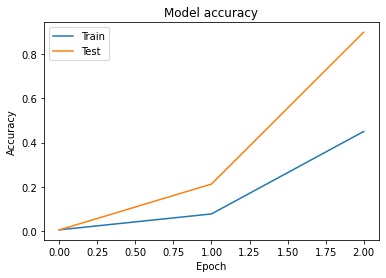

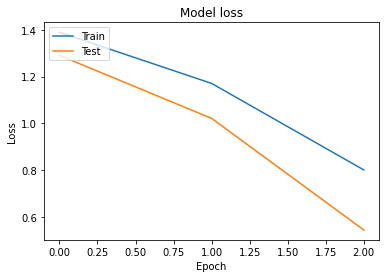

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Eval
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

              precision    recall  f1-score   support

        Meal       0.00      0.02      0.01        59
     No Meal       0.76      0.98      0.85      3496
         PAD       0.99      0.88      0.93      9975

    accuracy                           0.90     13530
   macro avg       0.58      0.62      0.60     13530
weighted avg       0.93      0.90      0.91     13530



In [ ]:
i = np.random.randint(0,X_te.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(glucose_vals[w-2], idx2tag[t], idx2tag[pred]))

Sample number 96 of 410 (Test Set)
Word           ||True ||Pred
          137.0: No Meal No Meal
          138.0: No Meal No Meal
          136.0: No Meal No Meal
          136.0: No Meal No Meal
          140.0: No Meal No Meal
          141.0: No Meal No Meal
          140.0: No Meal No Meal
          136.0: No Meal No Meal
